# Research Questions Exploration - RQ1: Pre-training Effectiveness

This notebook provides interactive exploration and visualization of the RQ1 analysis results.

**Research Question 1:** Does multi-task, cross-domain pre-training improve downstream performance compared to from-scratch training?

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define paths
RESULTS_DIR = Path('results')
FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(exist_ok=True)

## 1. Load Analysis Results

In [2]:
# Load all RQ1 results
improvement_df = pd.read_csv(RESULTS_DIR / 'rq1_improvement_analysis.csv')
statistical_df = pd.read_csv(RESULTS_DIR / 'rq1_statistical_tests.csv')
best_schemes_df = pd.read_csv(RESULTS_DIR / 'rq1_best_schemes.csv')

# Load summary tables
scheme_summary = pd.read_csv(RESULTS_DIR / 'rq1_summary_scheme_summary.csv', index_col=0)
significance_summary = pd.read_csv(RESULTS_DIR / 'rq1_summary_significance_summary.csv', index_col=0)
domain_best = pd.read_csv(RESULTS_DIR / 'rq1_summary_domain_best_schemes.csv', index_col=0)

print(f'Loaded {len(improvement_df)} improvement results')
print(f'Loaded {len(statistical_df)} statistical test results')
print('\nScheme Summary:')
print(scheme_summary)

Loaded 96 improvement results
Loaded 96 statistical test results

Scheme Summary:
        mean_improvement  std_improvement  min_improvement  max_improvement  \
scheme                                                                        
b2                 -0.39             6.15            -9.12            11.32   
s3                 -2.58             6.14           -10.11             9.43   
s1                 -2.67            16.89           -23.60            35.85   
s2                 -2.81             7.87           -14.07            15.76   
b4                 -4.04             4.68           -13.48             0.00   
b3                 -4.53            11.21           -26.97            17.05   
s5                 -5.85             7.95           -25.86             7.55   
s4                 -5.89             4.87           -15.81             2.06   

        n_combinations  
scheme                  
b2                  12  
s3                  12  
s1                  12  
s2

## 2. Overall Performance Summary

In [3]:
# Key statistics
mean_improvement = improvement_df['improvement_percent'].mean()
positive_improvements = (improvement_df['improvement_percent'] > 0).sum()
total_combinations = len(improvement_df)

print('=' * 60)
print('OVERALL SUMMARY')
print('=' * 60)
print(f'Mean improvement across all schemes: {mean_improvement:.2f}%')
print(f'Positive improvements: {positive_improvements}/{total_combinations} ({positive_improvements/total_combinations*100:.1f}%)')
print(f'\nBest performing scheme: {scheme_summary.index[0]} (mean: {scheme_summary.iloc[0]["mean_improvement"]:.2f}%)')
print(f'Worst performing scheme: {scheme_summary.index[-1]} (mean: {scheme_summary.iloc[-1]["mean_improvement"]:.2f}%)')

# Statistical significance
total_significant = significance_summary['n_significant'].sum()
total_tests = significance_summary['total_tests'].sum()
print(f'\nStatistically significant improvements: {total_significant}/{total_tests} ({total_significant/total_tests*100:.1f}%)')

OVERALL SUMMARY
Mean improvement across all schemes: -3.60%
Positive improvements: 22/96 (22.9%)

Best performing scheme: b2 (mean: -0.39%)
Worst performing scheme: s4 (mean: -5.89%)

Statistically significant improvements: 0/96 (0.0%)


## 3. Visualization 1: Box Plots of Improvement by Scheme

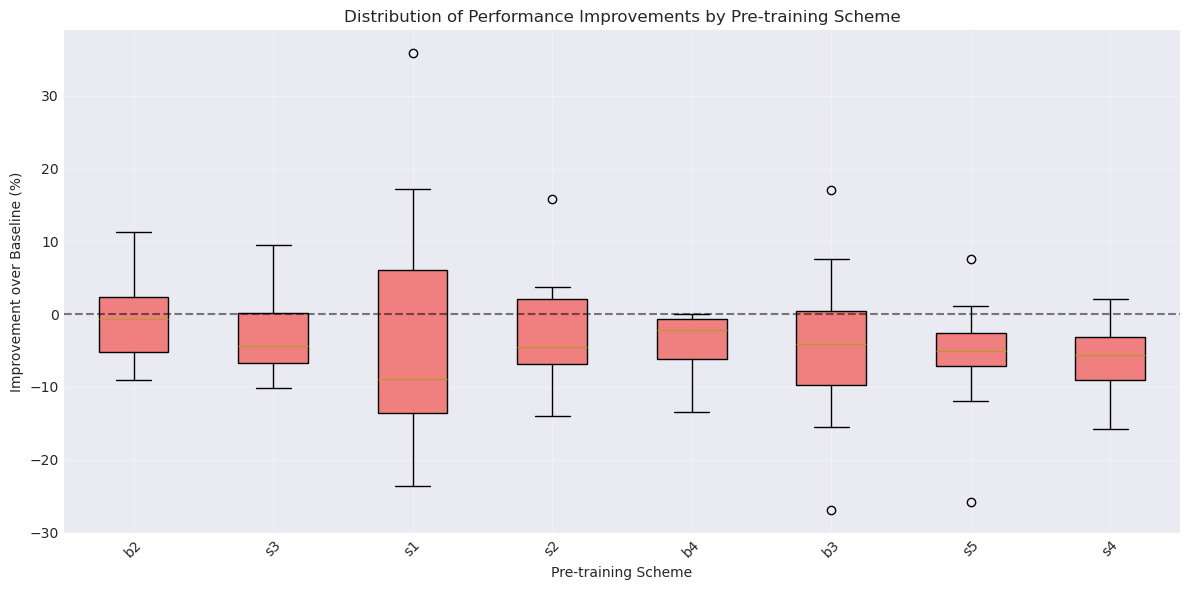

In [4]:
# Create box plot showing improvement distribution for each scheme
plt.figure(figsize=(12, 6))

# Order schemes by mean improvement
scheme_order = scheme_summary.sort_values('mean_improvement', ascending=False).index.tolist()

# Create box plot
data_for_plot = [improvement_df[improvement_df['scheme'] == scheme]['improvement_percent'].values 
                 for scheme in scheme_order]

bp = plt.boxplot(data_for_plot, labels=scheme_order, patch_artist=True)

# Color boxes based on positive/negative mean
for i, (patch, scheme) in enumerate(zip(bp['boxes'], scheme_order)):
    mean_val = scheme_summary.loc[scheme, 'mean_improvement']
    if mean_val > 0:
        patch.set_facecolor('lightgreen')
    else:
        patch.set_facecolor('lightcoral')

# Add zero line
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.xlabel('Pre-training Scheme')
plt.ylabel('Improvement over Baseline (%)')
plt.title('Distribution of Performance Improvements by Pre-training Scheme')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig(FIGURES_DIR / 'rq1_effectiveness_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Visualization 2: Improvement Heatmap (Domain × Scheme)

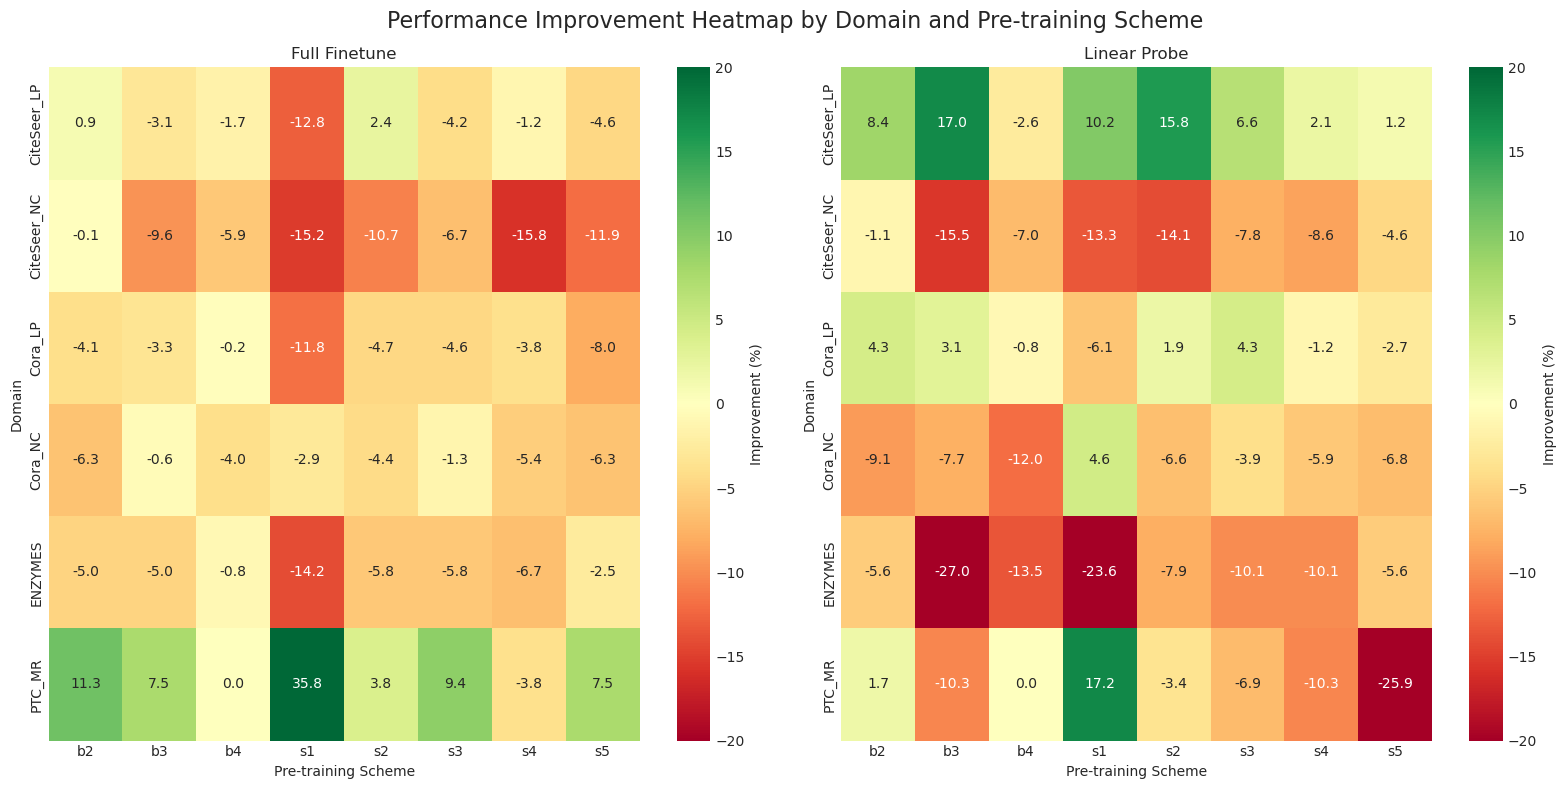

In [5]:
# Create heatmap showing improvement for each domain-scheme-strategy combination
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

strategies = improvement_df['strategy'].unique()

for idx, strategy in enumerate(strategies):
    # Filter data for this strategy
    strategy_data = improvement_df[improvement_df['strategy'] == strategy]
    
    # Create pivot table
    pivot_data = strategy_data.pivot_table(
        values='improvement_percent',
        index='domain',
        columns='scheme',
        aggfunc='mean'
    )
    
    # Plot heatmap
    ax = ax1 if idx == 0 else ax2
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=0, vmin=-20, vmax=20, ax=ax, cbar_kws={'label': 'Improvement (%)'})
    ax.set_title(f'{strategy.replace("_", " ").title()}')
    ax.set_xlabel('Pre-training Scheme')
    ax.set_ylabel('Domain')

plt.suptitle('Performance Improvement Heatmap by Domain and Pre-training Scheme', fontsize=16)
plt.tight_layout()

# Save figure
plt.savefig(FIGURES_DIR / 'rq1_improvement_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

---

## RQ2: Task Combination Analysis

**Research Question 2:** Which combinations of pre-training tasks are most effective for improving downstream performance?

This section analyzes how different task combinations interact and identifies the most effective strategies.


In [6]:
# Load RQ2 analysis results
try:
    # Task combination analysis
    combo_df = pd.read_csv(RESULTS_DIR / 'rq2_task_combination_analysis.csv')
    
    # Synergy analysis
    synergy_df = pd.read_csv(RESULTS_DIR / 'rq2_synergy_scores.csv')
    
    # Progressive comparisons
    progressive_df = pd.read_csv(RESULTS_DIR / 'rq2_progressive_comparisons.csv')
    
    # Summary tables
    task_type_eff = pd.read_csv(RESULTS_DIR / 'rq2_summary_task_type_effectiveness.csv', index_col=0)
    synergy_summary = pd.read_csv(RESULTS_DIR / 'rq2_summary_synergy_summary.csv', index_col=0)
    task_count_perf = pd.read_csv(RESULTS_DIR / 'rq2_summary_task_count_performance.csv', index_col=0)
    best_per_domain = pd.read_csv(RESULTS_DIR / 'rq2_summary_best_per_domain.csv', index_col=0)
    
    print("RQ2 analysis results loaded successfully!")
    print(f"Task combinations analyzed: {len(combo_df)} combinations")
    print(f"Synergy scores calculated: {len(synergy_df)} multi-task schemes")
    print(f"Progressive comparisons: {len(progressive_df)} statistical tests")
    
except FileNotFoundError as e:
    print(f"RQ2 results not found. Please run statistical analysis first.")
    print(f"Missing file: {e.filename}")
    combo_df = synergy_df = progressive_df = None
    task_type_eff = synergy_summary = task_count_perf = best_per_domain = None


RQ2 analysis results loaded successfully!
Task combinations analyzed: 96 combinations
Synergy scores calculated: 72 multi-task schemes
Progressive comparisons: 84 statistical tests


RQ2.1: TASK TYPE EFFECTIVENESS ANALYSIS

Task Type Performance Summary:
               improvement_pct_mean  improvement_pct_std  \
task_type                                                  
combined                     -2.583                6.138   
contrastive                  -2.814                7.871   
cross_domain                 -5.894                4.869   
full_adv                     -5.847                7.953   
generative                   -2.671               16.888   
single                       -2.460                9.092   
single_domain                -4.043                4.676   

               improvement_pct_count  scheme_performance_mean  \
task_type                                                       
combined                          12                    0.358   
contrastive                       12                    0.353   
cross_domain                      12                    0.344   
full_adv                          12                    0.347 

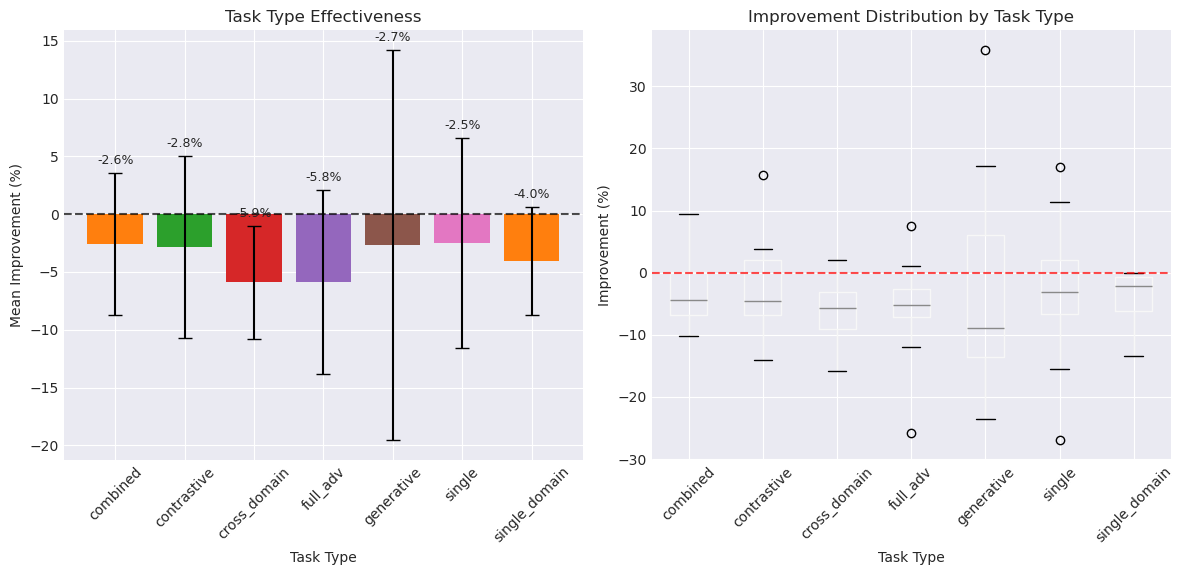

In [7]:
# RQ2.1: Task Type Effectiveness Analysis
if task_type_eff is not None:
    print("="*60)
    print("RQ2.1: TASK TYPE EFFECTIVENESS ANALYSIS")
    print("="*60)
    
    # Display task type effectiveness summary
    print("\nTask Type Performance Summary:")
    print(task_type_eff.round(3))
    
    # Identify best task type
    best_type = task_type_eff['improvement_pct_mean'].idxmax()
    best_improvement = task_type_eff.loc[best_type, 'improvement_pct_mean']
    
    print(f"\nBest Task Type: {best_type}")
    print(f"   Average Improvement: {best_improvement:.2f}%")
    print(f"   Standard Deviation: {task_type_eff.loc[best_type, 'improvement_pct_std']:.2f}%")
    print(f"   Number of Experiments: {task_type_eff.loc[best_type, 'improvement_pct_count']}")
    
    # Visualize task type effectiveness
    plt.figure(figsize=(12, 6))
    
    # Bar plot of mean improvements
    plt.subplot(1, 2, 1)
    means = task_type_eff['improvement_pct_mean']
    stds = task_type_eff['improvement_pct_std']
    
    bars = plt.bar(range(len(means)), means, yerr=stds, capsize=5, 
                   color=['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    plt.xlabel('Task Type')
    plt.ylabel('Mean Improvement (%)')
    plt.title('Task Type Effectiveness')
    plt.xticks(range(len(means)), means.index, rotation=45)
    
    # Add value labels on bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        plt.text(bar.get_x() + bar.get_width()/2, mean + std + 0.5, 
                f'{mean:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Box plot of improvement distributions
    plt.subplot(1, 2, 2)
    if combo_df is not None:
        combo_df.boxplot(column='improvement_pct', by='task_type', ax=plt.gca())
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Task Type')
        plt.ylabel('Improvement (%)')
        plt.title('Improvement Distribution by Task Type')
        plt.xticks(rotation=45)
        plt.suptitle('')  # Remove automatic title
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq2_task_type_effectiveness.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Task type effectiveness data not available. Run RQ2 analysis first.")


RQ2.2: TASK SYNERGY ANALYSIS

Task Synergy Summary:
               synergy_pct_mean  synergy_pct_std  synergy_pct_count  \
task_type                                                             
combined                 -3.428            3.925                 12   
contrastive              -3.740            4.481                 12   
cross_domain             -6.570            5.719                 12   
full_adv                 -6.552            8.018                 12   
generative               -3.847           13.338                 12   
single_domain            -4.729            5.652                 12   

               is_positive_synergy_sum  positive_synergy_rate  
task_type                                                      
combined                             1                    8.3  
contrastive                          2                   16.7  
cross_domain                         1                    8.3  
full_adv                             2                   16

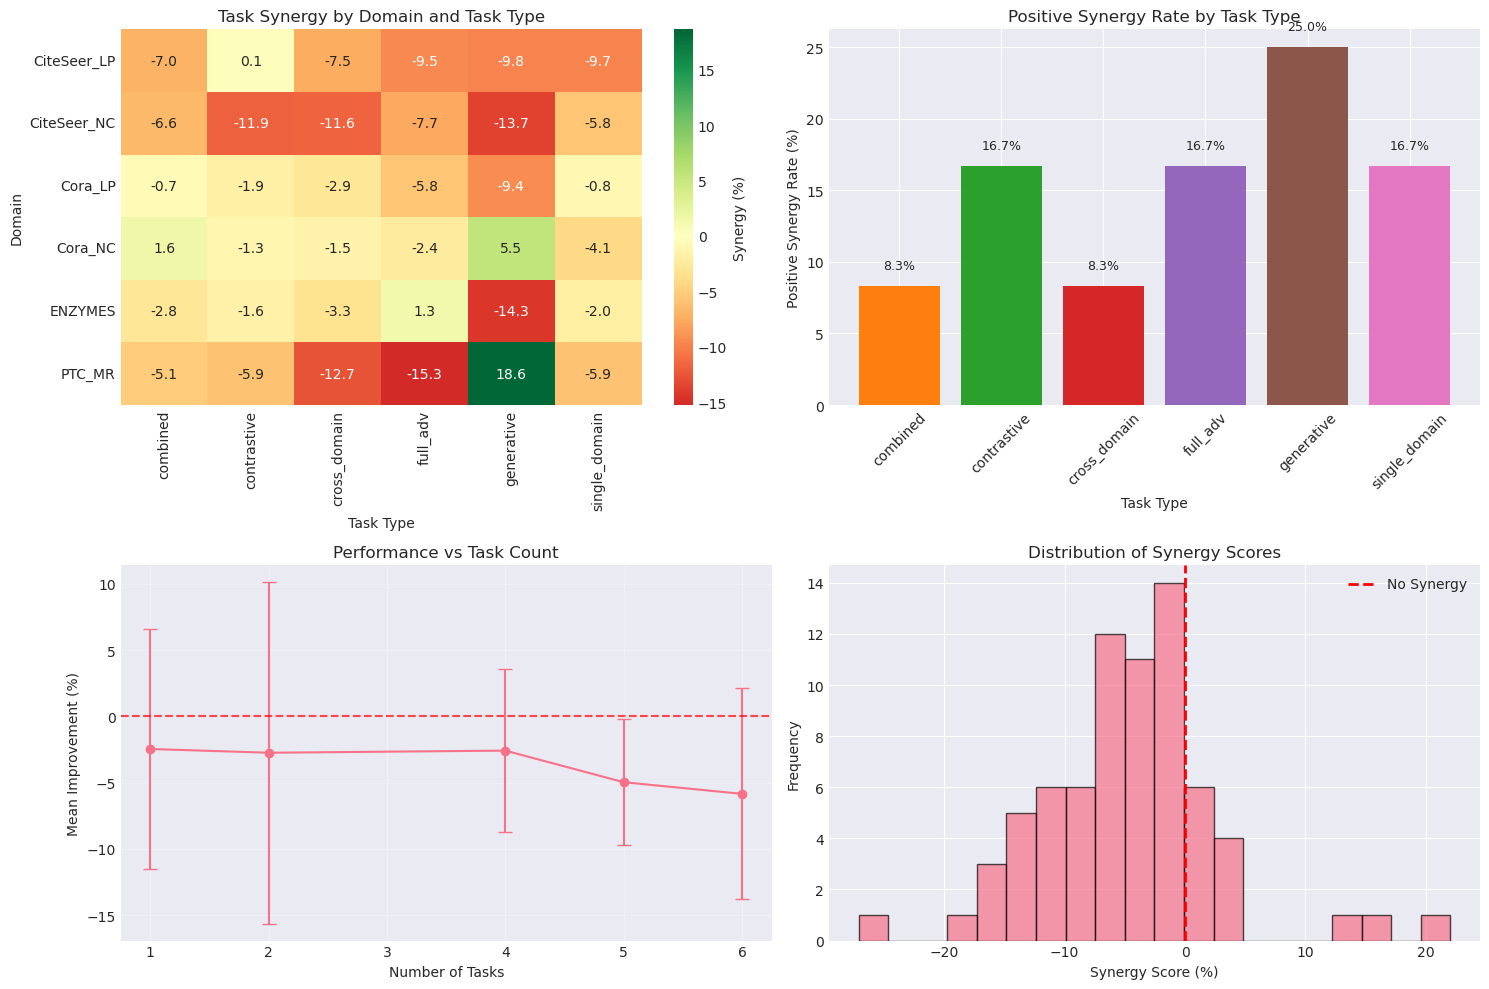

In [8]:
# RQ2.2: Task Synergy Analysis
if synergy_df is not None and synergy_summary is not None:
    print("="*60)
    print("RQ2.2: TASK SYNERGY ANALYSIS")
    print("="*60)
    
    # Display synergy summary
    print("\nTask Synergy Summary:")
    print(synergy_summary.round(3))
    
    # Identify best synergy type
    best_synergy_type = synergy_summary['positive_synergy_rate'].idxmax()
    best_synergy_rate = synergy_summary.loc[best_synergy_type, 'positive_synergy_rate']
    
    print(f"\nBest Synergy Task Type: {best_synergy_type}")
    print(f"   Positive Synergy Rate: {best_synergy_rate:.1f}%")
    print(f"   Average Synergy: {synergy_summary.loc[best_synergy_type, 'synergy_pct_mean']:.2f}%")
    
    # Overall synergy statistics
    total_positive = synergy_df['is_positive_synergy'].sum()
    total_combinations = len(synergy_df)
    overall_synergy_rate = (total_positive / total_combinations * 100) if total_combinations > 0 else 0
    
    print(f"\nOverall Synergy Statistics:")
    print(f"   Total combinations analyzed: {total_combinations}")
    print(f"   Positive synergy combinations: {total_positive}")
    print(f"   Overall positive synergy rate: {overall_synergy_rate:.1f}%")
    
    # Visualize synergy analysis
    plt.figure(figsize=(15, 10))
    
    # 1. Synergy heatmap by domain and task type
    plt.subplot(2, 2, 1)
    pivot_synergy = synergy_df.pivot_table(values='synergy_pct', index='domain', 
                                          columns='task_type', aggfunc='mean')
    sns.heatmap(pivot_synergy, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Synergy (%)'})
    plt.title('Task Synergy by Domain and Task Type')
    plt.xlabel('Task Type')
    plt.ylabel('Domain')
    
    # 2. Positive synergy rate by task type
    plt.subplot(2, 2, 2)
    pos_rates = synergy_summary['positive_synergy_rate']
    bars = plt.bar(range(len(pos_rates)), pos_rates, 
                   color=['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
    plt.xlabel('Task Type')
    plt.ylabel('Positive Synergy Rate (%)')
    plt.title('Positive Synergy Rate by Task Type')
    plt.xticks(range(len(pos_rates)), pos_rates.index, rotation=45)
    
    # Add value labels
    for bar, rate in zip(bars, pos_rates):
        plt.text(bar.get_x() + bar.get_width()/2, rate + 1, 
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. Synergy vs task count
    plt.subplot(2, 2, 3)
    if task_count_perf is not None:
        task_counts = task_count_perf.index
        improvements = task_count_perf['improvement_pct_mean']
        stds = task_count_perf['improvement_pct_std']
        
        plt.errorbar(task_counts, improvements, yerr=stds, marker='o', capsize=5)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Number of Tasks')
        plt.ylabel('Mean Improvement (%)')
        plt.title('Performance vs Task Count')
        plt.grid(True, alpha=0.3)
    
    # 4. Distribution of synergy scores
    plt.subplot(2, 2, 4)
    synergy_df['synergy_pct'].hist(bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Synergy')
    plt.xlabel('Synergy Score (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Synergy Scores')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq2_synergy_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Synergy analysis data not available. Run RQ2 analysis first.")


RQ2.3: PROGRESSIVE TASK COMBINATION ANALYSIS

Progressive Comparison Results:
   Total comparisons: 84
   Significant improvements: 0
   Success rate: 0.0%

Comparison Categories Summary:
            improvement_pct_mean  improvement_pct_std  improvement_pct_count  \
comparison                                                                     
b2 vs s1                  -2.512               13.730                     12   
b3 vs s2                   2.434                8.209                     12   
s1 vs s3                   1.931               12.333                     12   
s2 vs s3                   0.455                4.744                     12   
s3 vs s4                  -3.258                4.322                     12   
s4 vs b4                   2.129                5.796                     12   
s4 vs s5                   0.068                7.130                     12   

            significant_corrected_sum  success_rate  
comparison                           

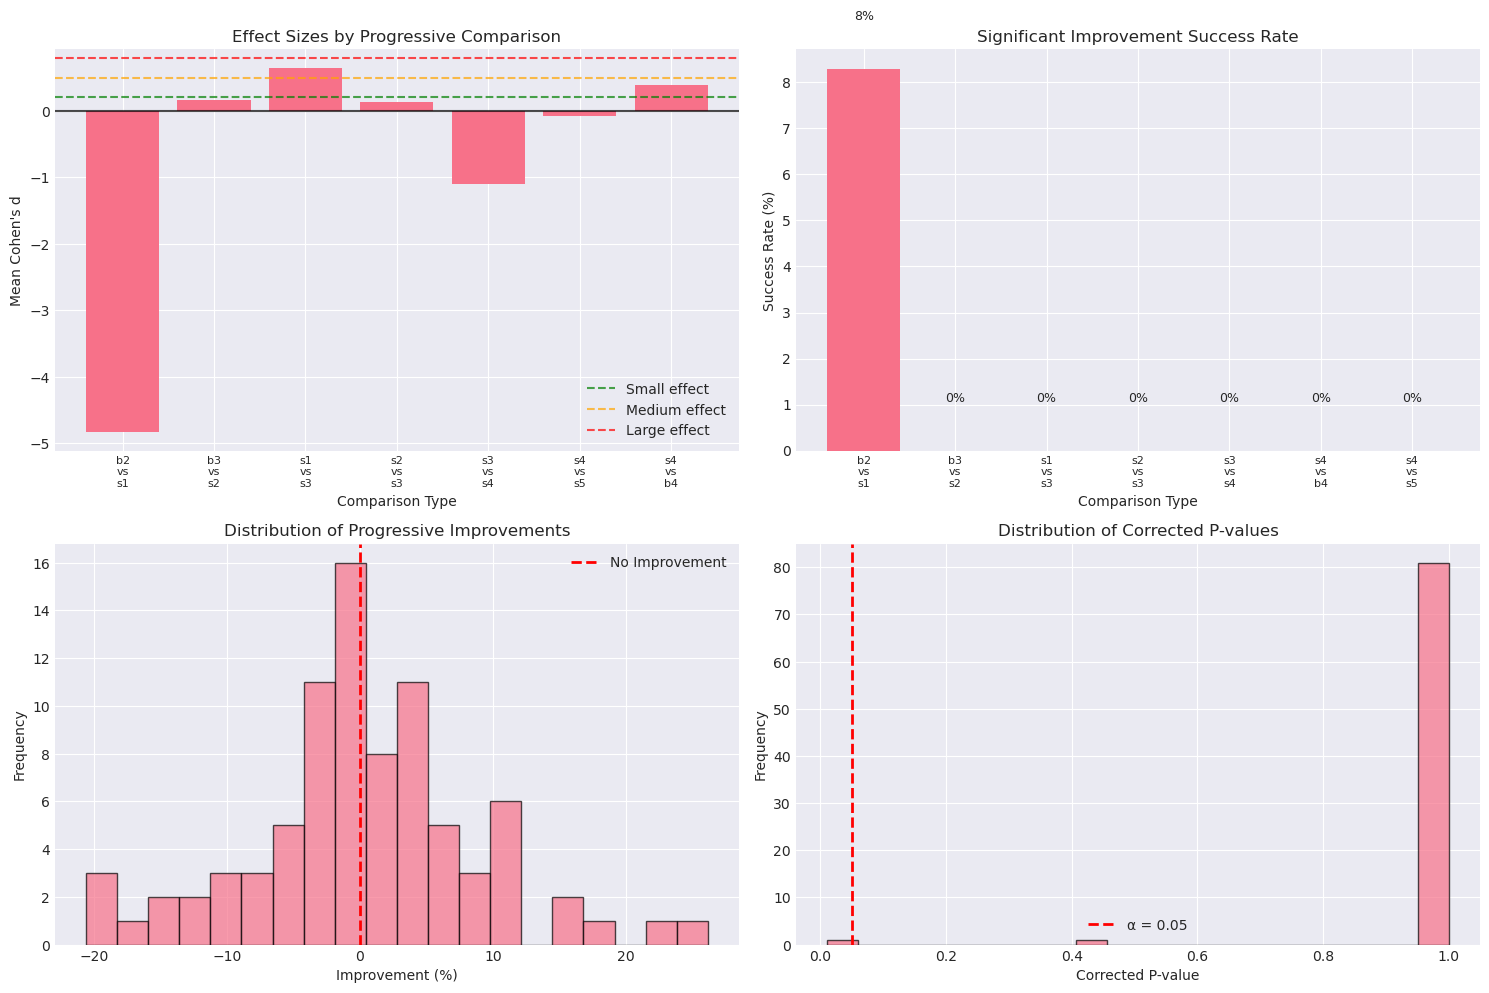

In [9]:
# RQ2.3: Progressive Task Combination Analysis
if progressive_df is not None:
    print("="*60)
    print("RQ2.3: PROGRESSIVE TASK COMBINATION ANALYSIS")
    print("="*60)
    
    # Filter for significant improvements
    sig_improvements = progressive_df[
        progressive_df['significant_corrected'] & (progressive_df['improvement_pct'] > 0)
    ]
    
    print(f"\nProgressive Comparison Results:")
    print(f"   Total comparisons: {len(progressive_df)}")
    print(f"   Significant improvements: {len(sig_improvements)}")
    print(f"   Success rate: {len(sig_improvements)/len(progressive_df)*100:.1f}%")
    
    if not sig_improvements.empty:
        # Show best progressive improvements
        best_improvements = sig_improvements.nlargest(5, 'improvement_pct')
        print(f"\nTop 5 Significant Progressive Improvements:")
        for idx, row in best_improvements.iterrows():
            print(f"   {row['comparison']}: +{row['improvement_pct']:.2f}% "
                  f"(p={row['p_value_corrected']:.4f}, d={row['cohens_d']:.2f})")
            print(f"      {row['description']}")
    
    # Detailed comparison analysis
    print(f"\nComparison Categories Summary:")
    comparison_summary = progressive_df.groupby('comparison').agg({
        'improvement_pct': ['mean', 'std', 'count'],
        'significant_corrected': 'sum'
    }).round(3)
    comparison_summary.columns = ['_'.join(col) for col in comparison_summary.columns]
    comparison_summary['success_rate'] = (comparison_summary['significant_corrected_sum'] / 
                                         comparison_summary['improvement_pct_count'] * 100).round(1)
    
    print(comparison_summary)
    
    # Visualize progressive comparisons
    plt.figure(figsize=(15, 10))
    
    # 1. Effect sizes by comparison type
    plt.subplot(2, 2, 1)
    comparison_types = progressive_df['comparison'].unique()
    effect_sizes = [progressive_df[progressive_df['comparison'] == comp]['cohens_d'].mean() 
                   for comp in comparison_types]
    
    bars = plt.bar(range(len(comparison_types)), effect_sizes)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
    plt.axhline(y=0.2, color='green', linestyle='--', alpha=0.7, label='Small effect')
    plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium effect')
    plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Large effect')
    plt.xlabel('Comparison Type')
    plt.ylabel('Mean Cohen\'s d')
    plt.title('Effect Sizes by Progressive Comparison')
    plt.xticks(range(len(comparison_types)), [c.split(' vs ')[0] + '\nvs\n' + c.split(' vs ')[1] 
                                             for c in comparison_types], fontsize=8)
    plt.legend()
    
    # 2. Success rate by comparison
    plt.subplot(2, 2, 2)
    success_rates = comparison_summary['success_rate']
    bars = plt.bar(range(len(success_rates)), success_rates)
    plt.xlabel('Comparison Type')
    plt.ylabel('Success Rate (%)')
    plt.title('Significant Improvement Success Rate')
    plt.xticks(range(len(success_rates)), [c.split(' vs ')[0] + '\nvs\n' + c.split(' vs ')[1] 
                                          for c in success_rates.index], fontsize=8)
    
    # Add value labels
    for bar, rate in zip(bars, success_rates):
        plt.text(bar.get_x() + bar.get_width()/2, rate + 1, 
                f'{rate:.0f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. Improvement distribution
    plt.subplot(2, 2, 3)
    progressive_df['improvement_pct'].hist(bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Improvement')
    plt.xlabel('Improvement (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Progressive Improvements')
    plt.legend()
    
    # 4. P-value distribution
    plt.subplot(2, 2, 4)
    progressive_df['p_value_corrected'].hist(bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
    plt.xlabel('Corrected P-value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Corrected P-values')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq2_progressive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Progressive comparison data not available. Run RQ2 analysis first.")


RQ2.4: BEST TASK COMBINATIONS PER DOMAIN

Best Task Combination for Each Domain-Strategy Pair:
         domain       strategy scheme      task_type  improvement_pct
91  CiteSeer_LP  full_finetune     s2    contrastive            2.354
81  CiteSeer_LP   linear_probe     b3         single           17.050
56  CiteSeer_NC  full_finetune     b2         single           -0.147
48  CiteSeer_NC   linear_probe     b2         single           -1.119
79      Cora_LP  full_finetune     b4  single_domain           -0.174
64      Cora_LP   linear_probe     b2         single            4.292
41      Cora_NC  full_finetune     b3         single           -0.559
34      Cora_NC   linear_probe     s1     generative            4.630
15      ENZYMES  full_finetune     b4  single_domain           -0.833
0       ENZYMES   linear_probe     b2         single           -5.618
26       PTC_MR  full_finetune     s1     generative           35.849
18       PTC_MR   linear_probe     s1     generative           17

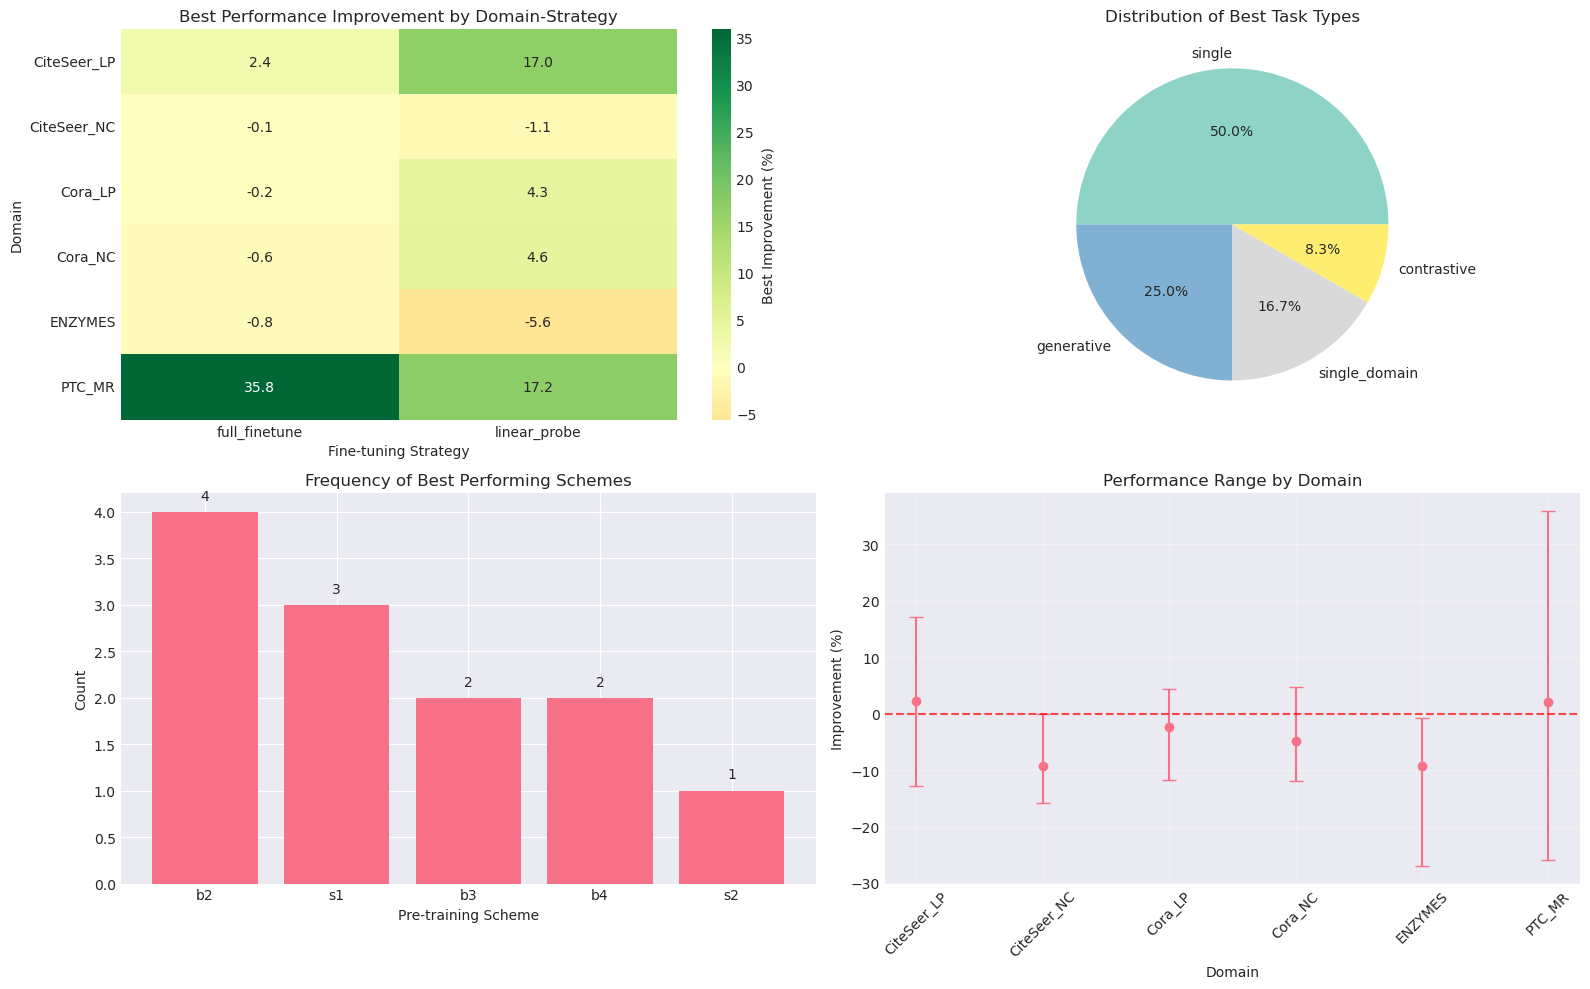


Key Insights:
   Most frequent best task type: single
   Most frequent best scheme: b2
   Average best improvement: 6.08%
   Domains with positive best improvements: 6/12


In [10]:
# RQ2.4: Best Task Combinations per Domain
if best_per_domain is not None:
    print("="*60)
    print("RQ2.4: BEST TASK COMBINATIONS PER DOMAIN")
    print("="*60)
    
    # Display best combinations
    print("\nBest Task Combination for Each Domain-Strategy Pair:")
    print(best_per_domain.round(3))
    
    # Create a comprehensive summary visualization
    plt.figure(figsize=(16, 10))
    
    # 1. Best scheme heatmap
    plt.subplot(2, 2, 1)
    pivot_best = best_per_domain.pivot_table(values='improvement_pct', 
                                            index='domain', columns='strategy', 
                                            aggfunc='mean')
    sns.heatmap(pivot_best, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Best Improvement (%)'})
    plt.title('Best Performance Improvement by Domain-Strategy')
    plt.xlabel('Fine-tuning Strategy')
    plt.ylabel('Domain')
    
    # 2. Task type distribution of best performers
    plt.subplot(2, 2, 2)
    task_type_counts = best_per_domain['task_type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(task_type_counts)))
    wedges, texts, autotexts = plt.pie(task_type_counts.values, labels=task_type_counts.index, 
                                      autopct='%1.1f%%', colors=colors)
    plt.title('Distribution of Best Task Types')
    
    # 3. Scheme distribution of best performers  
    plt.subplot(2, 2, 3)
    scheme_counts = best_per_domain['scheme'].value_counts()
    bars = plt.bar(range(len(scheme_counts)), scheme_counts.values)
    plt.xlabel('Pre-training Scheme')
    plt.ylabel('Count')
    plt.title('Frequency of Best Performing Schemes')
    plt.xticks(range(len(scheme_counts)), scheme_counts.index)
    
    # Add value labels
    for bar, count in zip(bars, scheme_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, count + 0.1, 
                str(count), ha='center', va='bottom')
    
    # 4. Performance range analysis
    plt.subplot(2, 2, 4)
    if combo_df is not None:
        domain_perf = combo_df.groupby('domain')['improvement_pct'].agg(['min', 'max', 'mean'])
        x_pos = np.arange(len(domain_perf))
        
        plt.errorbar(x_pos, domain_perf['mean'], 
                    yerr=[domain_perf['mean'] - domain_perf['min'], 
                          domain_perf['max'] - domain_perf['mean']], 
                    fmt='o', capsize=5)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Domain')
        plt.ylabel('Improvement (%)')
        plt.title('Performance Range by Domain')
        plt.xticks(x_pos, domain_perf.index, rotation=45)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq2_best_combinations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary insights
    print(f"\nKey Insights:")
    most_frequent_type = best_per_domain['task_type'].mode().iloc[0]
    most_frequent_scheme = best_per_domain['scheme'].mode().iloc[0]
    avg_best_improvement = best_per_domain['improvement_pct'].mean()
    
    print(f"   Most frequent best task type: {most_frequent_type}")
    print(f"   Most frequent best scheme: {most_frequent_scheme}")
    print(f"   Average best improvement: {avg_best_improvement:.2f}%")
    print(f"   Domains with positive best improvements: {(best_per_domain['improvement_pct'] > 0).sum()}/{len(best_per_domain)}")
    
else:
    print("Best per domain data not available. Run RQ2 analysis first.")
